In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

In [14]:
# Getting the Data
test_df = pd.read_csv("../datasets/titanic/test.csv")
train_df = pd.read_csv("../datasets/titanic/train.csv")

In [3]:
# Data Exploration/Analysis
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The training-set has 891 examples and 11 features + the target variable (survived). 2 of the features are floats, 5 are integers and 5 are objects. Below I have listed the features with a short description:

survival:    Survival 
PassengerId: Unique Id of a passenger. 
pclass:    Ticket class     
sex:    Sex     
Age:    Age in years     
sibsp:    # of siblings / spouses aboard the Titanic     
parch:    # of parents / children aboard the Titanic     
ticket:    Ticket number     
fare:    Passenger fare     
cabin:    Cabin number     
embarked:    Port of Embarkation
train_df.describe()

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Above we can see that 38% out of the training-set survived the Titanic. We can also see that the passenger ages range from 0.4 to 80. On top of that we can already detect some features, that contain missing values, like the ‘Age’ feature.

In [5]:
train_df.head(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


From the table above, we can note a few things. First of all, that we need to convert a lot of features into numeric ones later on, so that the machine learning algorithms can process them. Furthermore, we can see that the features have widely different ranges, that we will need to convert into roughly the same scale. We can also spot some more features, that contain missing values (NaN = not a number), that wee need to deal with.

Let’s take a more detailed look at what data is actually missing:

In [6]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


The Embarked feature has only 2 missing values, which can easily be filled. It will be much more tricky, to deal with the ‘Age’ feature, which has 177 missing values. The ‘Cabin’ feature needs further investigation, but it looks like that we might want to drop it from the dataset, since 77 % of it are missing.

In [7]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

Above you can see the 11 features + the target variable (survived). What features could contribute to a high survival rate ?

To me it would make sense if everything except ‘PassengerId’, ‘Ticket’ and ‘Name’ would be correlated with a high survival rate.

1. Age and Sex:

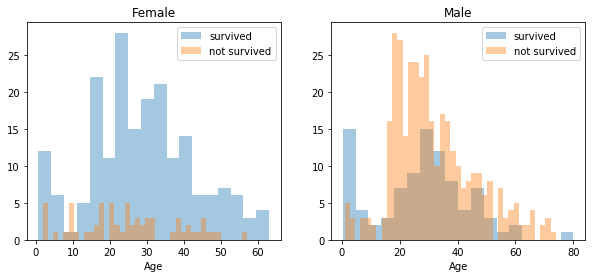

In [8]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

You can see that men have a high probability of survival when they are between 18 and 30 years old, which is also a little bit true for women but not fully. For women the survival chances are higher between 14 and 40.

For men the probability of survival is very low between the age of 5 and 18, but that isn’t true for women. Another thing to note is that infants also have a little bit higher probability of survival.

Since there seem to be certain ages, which have increased odds of survival and because I want every feature to be roughly on the same scale, I will create age groups later on.

3. Embarked, Pclass and Sex:

/home/alicia/workspace/intro_ml_python/venv/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


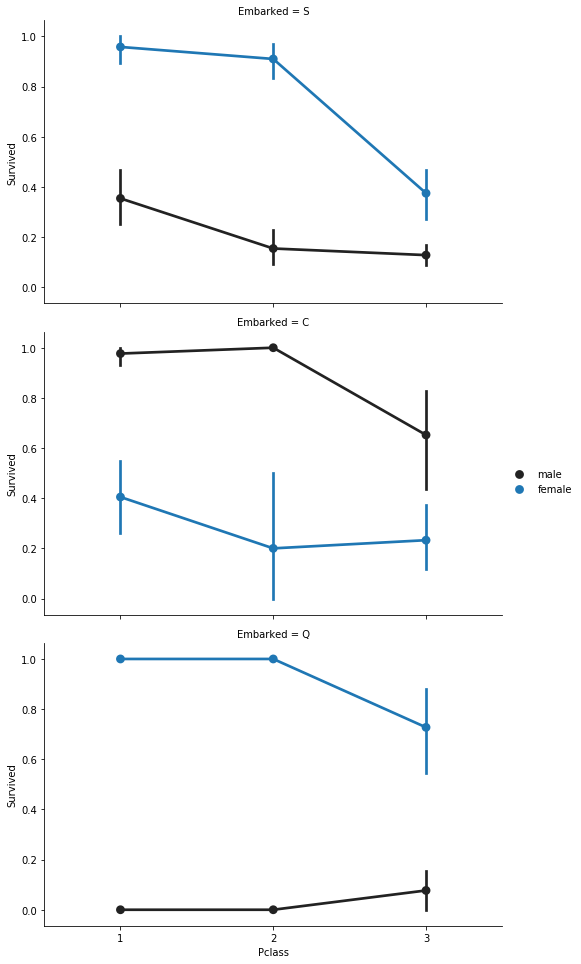

In [9]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()


Embarked seems to be correlated with survival, depending on the gender.

Women on port Q and on port S have a higher chance of survival. The inverse is true, if they are at port C. Men have a high survival probability if they are on port C, but a low probability if they are on port Q or S.

Pclass also seems to be correlated with survival. We will generate another plot of it below.

4. Pclass:

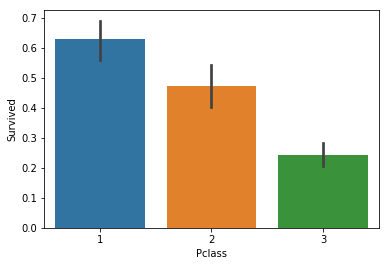

In [10]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

Here we see clearly, that Pclass is contributing to a persons chance of survival, especially if this person is in class 1. We will create another pclass plot below.

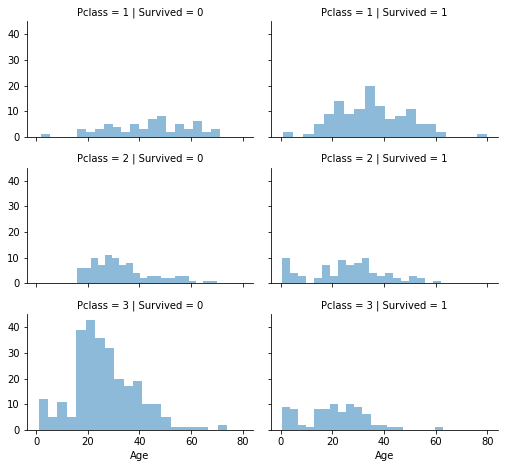

In [11]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

The plot above confirms our assumption about pclass 1, but we can also spot a high probability that a person in pclass 3 will not survive.

5. SibSp and Parch:

SibSp and Parch would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic. I will create it below and also a feature that sows if someone is not alone.

In [12]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_df['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

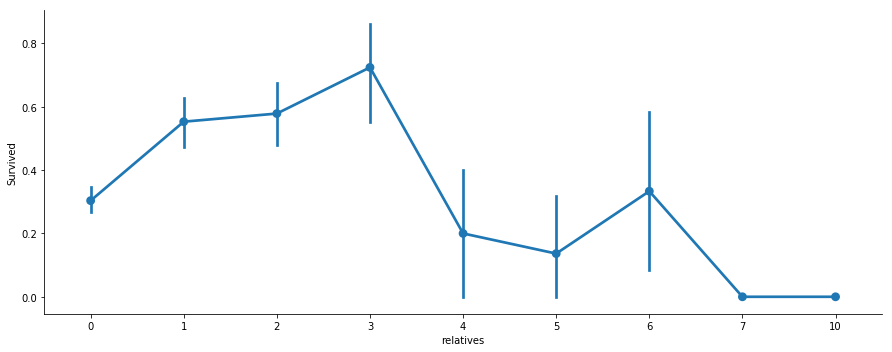

In [17]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, )

Here we can see that you had a high probabilty of survival with 1 to 3 realitves, but a lower one if you had less than 1 or more than 3 (except for some cases with 6 relatives).

[ref](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8)